In [1]:
from sentinelhub import SHConfig, BBox, CRS, DataCollection, bbox_to_dimensions, SentinelHubRequest, MimeType
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
#from IPython.display import Image
import cv2
import numpy as np
import json
import requests
from PIL import Image
import io

In [3]:
def get_access_token(client_id, client_secret):
    url = "https://services.sentinel-hub.com/oauth/token"
    payload = {
        'client_id': client_id,
        'client_secret': client_secret,
        'grant_type': 'client_credentials'
    }
    headers = {
        'Content-Type': 'application/x-www-form-urlencoded'
    }

    response = requests.post(url, data=payload, headers=headers)

    if response.ok:
        return response.json().get('access_token')
    else:
        raise Exception(f"Error obtaining token: {response.text}")


def fetch_image(access_token, collection_id, time_from, time_to, geometry):
    url = "https://services.sentinel-hub.com/api/v1/process"
    headers = {
        "Authorization": f"Bearer {access_token}",
        "Content-Type": "application/json"
    }
    payload = {
        "input": {
            "bounds": {
                "properties": {
                    "crs": "http://www.opengis.net/def/crs/EPSG/0/4326"
                },
                "geometry": geometry
            },
            "data": [{
                "type": f"byoc-{collection_id}",
                "dataFilter": {
                    "timeRange": {
                        "from": time_from,
                        "to": time_to
                    }
                }
            }]
        },
        "output": {
            "width": 2000,
            "height": 2000
        },
        "evalscript": """
        //VERSION=3
        //False Color

        function setup() {
          return {
            input: ["red", "green", "nir", "dataMask"],
            output: { bands: 4 }
          };
        }

        function evaluatePixel(sample) {
          return [sample.nir/3000, 
                  sample.red/3000, 
                  sample.green/3000,
                  sample.dataMask];
        }
        """
    }

    response = requests.post(url, headers=headers, json=payload)
    if response.status_code == 200:
        # Assuming the response is an image
        image_path = f"output_{collection_id}.png"
        with open(image_path, 'wb') as file:
            file.write(response.content)
        print(f"Image saved to {image_path}.")
    else:
        print(f"Failed to fetch image: {response.status_code} - {response.text}")



client_id = '9a5c8df7-077a-4d3c-8705-65c9019d75ed'
client_secret = '7yq74fjN7uIe0lq9cIuUcmQrwdfQBkVR'
access_token = get_access_token(client_id, client_secret)

collection_id = 'b88c67ae-a815-4854-8f87-99dd1bd01c16'

geometry = {
  "type": "Polygon",
  "coordinates": [
    [
      [
        118.226624,
        -8.658627
      ],
      [
        118.227353,
        -8.658987
      ],
      [
        118.228168,
        -8.658966
      ],
      [
        118.228898,
        -8.659709
      ],
      [
        118.229949,
        -8.659963
      ],
      [
        118.230314,
        -8.661406
      ],
      [
        118.229928,
        -8.662912
      ],
      [
        118.228984,
        -8.665606
      ],
      [
        118.227718,
        -8.6662
      ],
      [
        118.225744,
        -8.666157
      ],
      [
        118.223877,
        -8.665988
      ],
      [
        118.222611,
        -8.665266
      ],
      [
        118.223062,
        -8.663591
      ],
      [
        118.222203,
        -8.662975
      ],
      [
        118.221796,
        -8.663251
      ],
      [
        118.221195,
        -8.662997
      ],
      [
        118.220057,
        -8.663739
      ],
      [
        118.218899,
        -8.663548
      ],
      [
        118.21774,
        -8.663803
      ],
      [
        118.217397,
        -8.660621
      ],
      [
        118.217311,
        -8.657481
      ],
      [
        118.217826,
        -8.654469
      ],
      [
        118.219221,
        -8.652051
      ],
      [
        118.219886,
        -8.652475
      ],
      [
        118.220873,
        -8.652454
      ],
      [
        118.221946,
        -8.652602
      ],
      [
        118.222632,
        -8.653111
      ],
      [
        118.221903,
        -8.655508
      ],
      [
        118.222396,
        -8.657184
      ],
      [
        118.223512,
        -8.658415
      ],
      [
        118.225057,
        -8.658754
      ],
      [
        118.226624,
        -8.658627
      ]
    ]
  ]
}  # Your AOI coordinates
time_from = "2024-05-20T00:00:00.000Z"
time_to = "2024-05-24T00:00:00.000Z"
fetch_image(access_token, collection_id, time_from, time_to, geometry)

Image saved to output_b88c67ae-a815-4854-8f87-99dd1bd01c16.png.


In [5]:
# Convert BytesIO to bytes
image_bytes = image_data.getvalue()

# Convert bytes to a NumPy array
image_array = np.frombuffer(image_bytes, dtype=np.uint8)

# Decode the array into an image
image_cv2 = cv2.imdecode(image_array, cv2.IMREAD_COLOR)

In [6]:
# Function to perform linear stretch of the image
def linear_stretch(image, lower_percent=2, upper_percent=98):
    # Convert image to float and calculate the percentiles
    v = np.percentile(image, [lower_percent, upper_percent])
    # Clip and scale the image pixel values
    image = np.clip(image, v[0], v[1])
    image = (image - v[0]) / (v[1] - v[0]) * 255
    image = image.astype(np.uint8)
    return image

# Function to apply gamma correction
def adjust_gamma(image, gamma=1.0):
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255 for i in np.arange(0, 256)]).astype("uint8")
    return cv2.LUT(image, table)

# Assuming 'image_cv2' is your OpenCV image loaded from the Sentinel Hub
# First, apply a linear stretch
image_stretched = linear_stretch(image_cv2)

# Then, apply gamma correction with a gamma value less than 1 to brighten the image
gamma_corrected_image = adjust_gamma(image_stretched, gamma=0.5)

# Display the enhanced image
cv2.imshow('Enhanced True Color Image', gamma_corrected_image)
cv2.waitKey(0)
cv2.destroyAllWindows()

2024-05-17 13:14:35.706 Python[11587:142483] WARNING: Secure coding is not enabled for restorable state! Enable secure coding by implementing NSApplicationDelegate.applicationSupportsSecureRestorableState: and returning YES.


: 

In [11]:
img_path = 'seaweed_indo.jpg'
img = cv2.imread(img_path)

# OpenCV reads images in BGR format by default. If your image is in RGB, convert it to BGR
img_rgb = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

# Convert the image from BGR to HSV
img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

# Convert the image to grayscale
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)



# Segmentation by HSV color differentiation

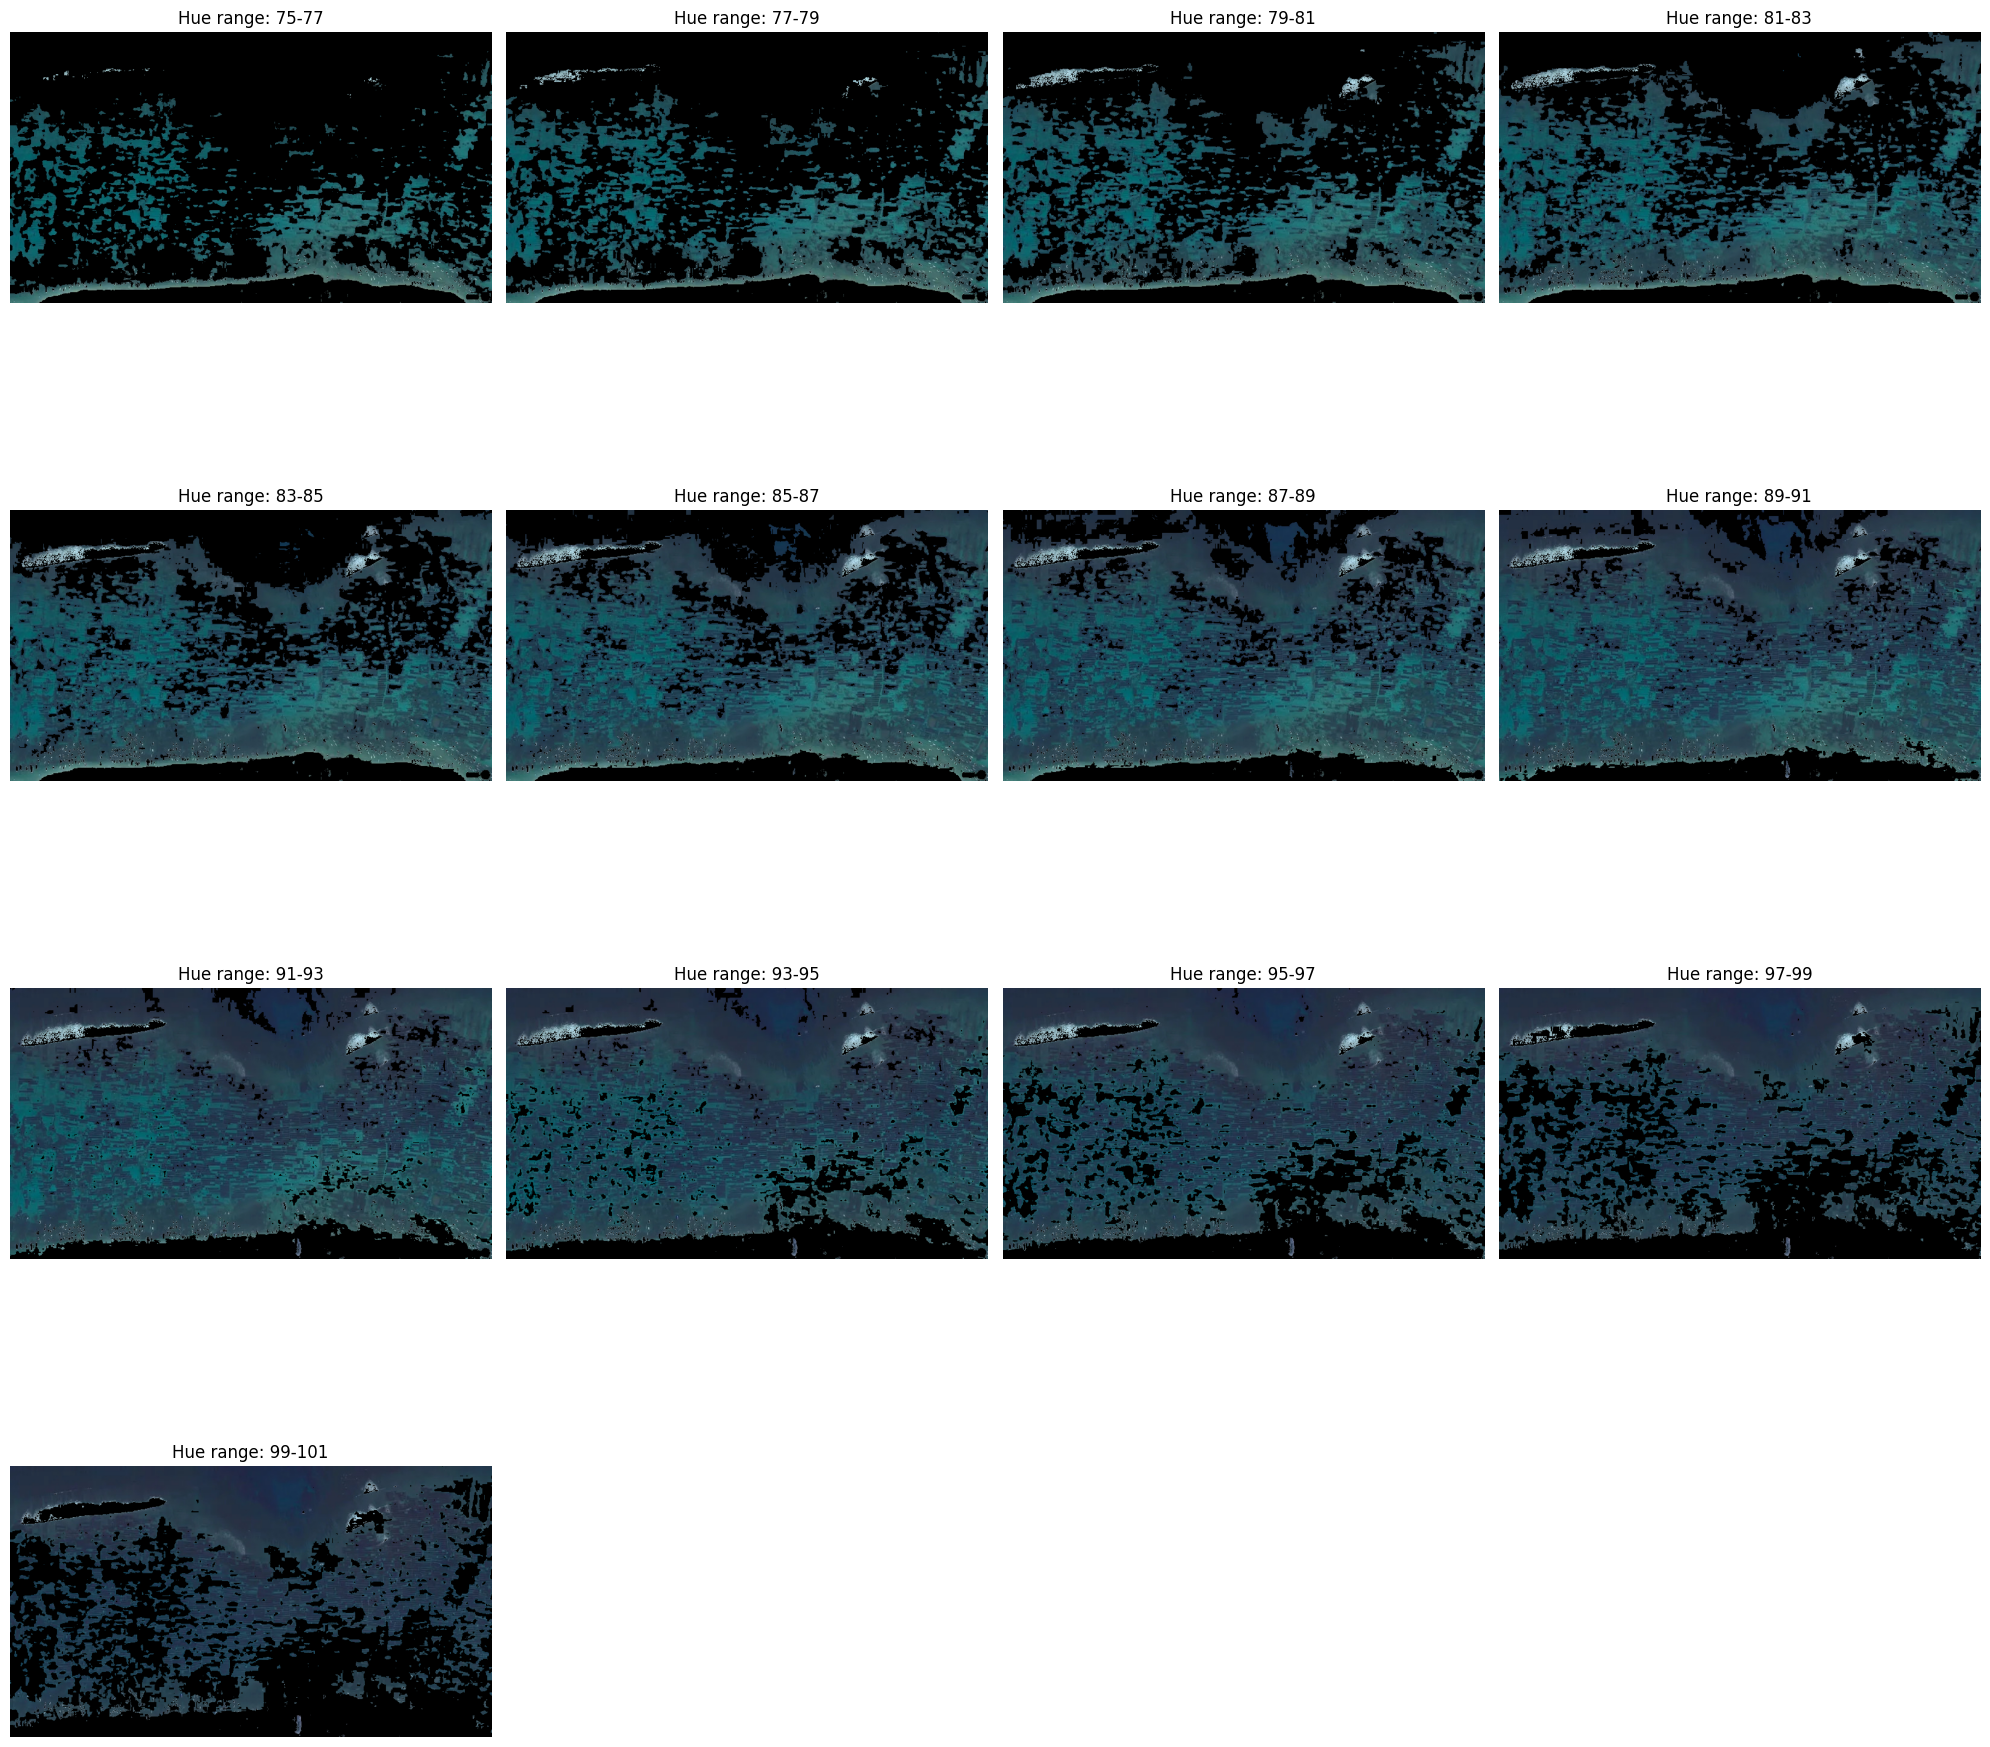

In [12]:
# Function to perform color-based segmentation with given HSV thresholds
def segment_hsv(image_hsv, lower_bound, upper_bound):
    mask = cv2.inRange(image_hsv, lower_bound, upper_bound)
    return cv2.bitwise_and(img, img, mask=mask)

# Generate a range of thresholds for hue, with fixed saturation and value ranges
# We'll iterate over a range of hue values since hue represents the color tone
hue_ranges = range(75, 100, 2)  # Hue values from 10 to 170 with a step of 20
sat_val = (50, 255)  # Saturation from 50 to 255 and value from 50 to 255

# List to store the resulting segmented images
segmented_images = []

# Iterate over the hue range to create and apply different thresholds
for h in hue_ranges:
    lower_hsv = np.array([h, sat_val[0], sat_val[0]])
    upper_hsv = np.array([h + 20, sat_val[1], sat_val[1]])  # A range of 20 for the hue
    segmented_img = segment_hsv(img_hsv, lower_hsv, upper_hsv)
    segmented_images.append(segmented_img)

# Calculate the number of rows and columns required to display all images
num_images = len(segmented_images)
num_columns = 4
num_rows = num_images // num_columns + (num_images % num_columns > 0)

# Display the segmented images
plt.figure(figsize=(20, 5 * num_rows))  # Adjust the figure size accordingly
for i, segmented_img in enumerate(segmented_images):
    plt.subplot(num_rows, num_columns, i + 1)  # Dynamic subplot indexing
    plt.imshow(cv2.cvtColor(segmented_img, cv2.COLOR_BGR2RGB))
    plt.title(f'Hue range: {hue_ranges[i]}-{hue_ranges[i] + 2}')
    plt.axis('off')

plt.tight_layout()
plt.show()

# Image Segmentation by grayscale

Results can be seen below, this analysis is great for identifying ROI's where seaweed is present

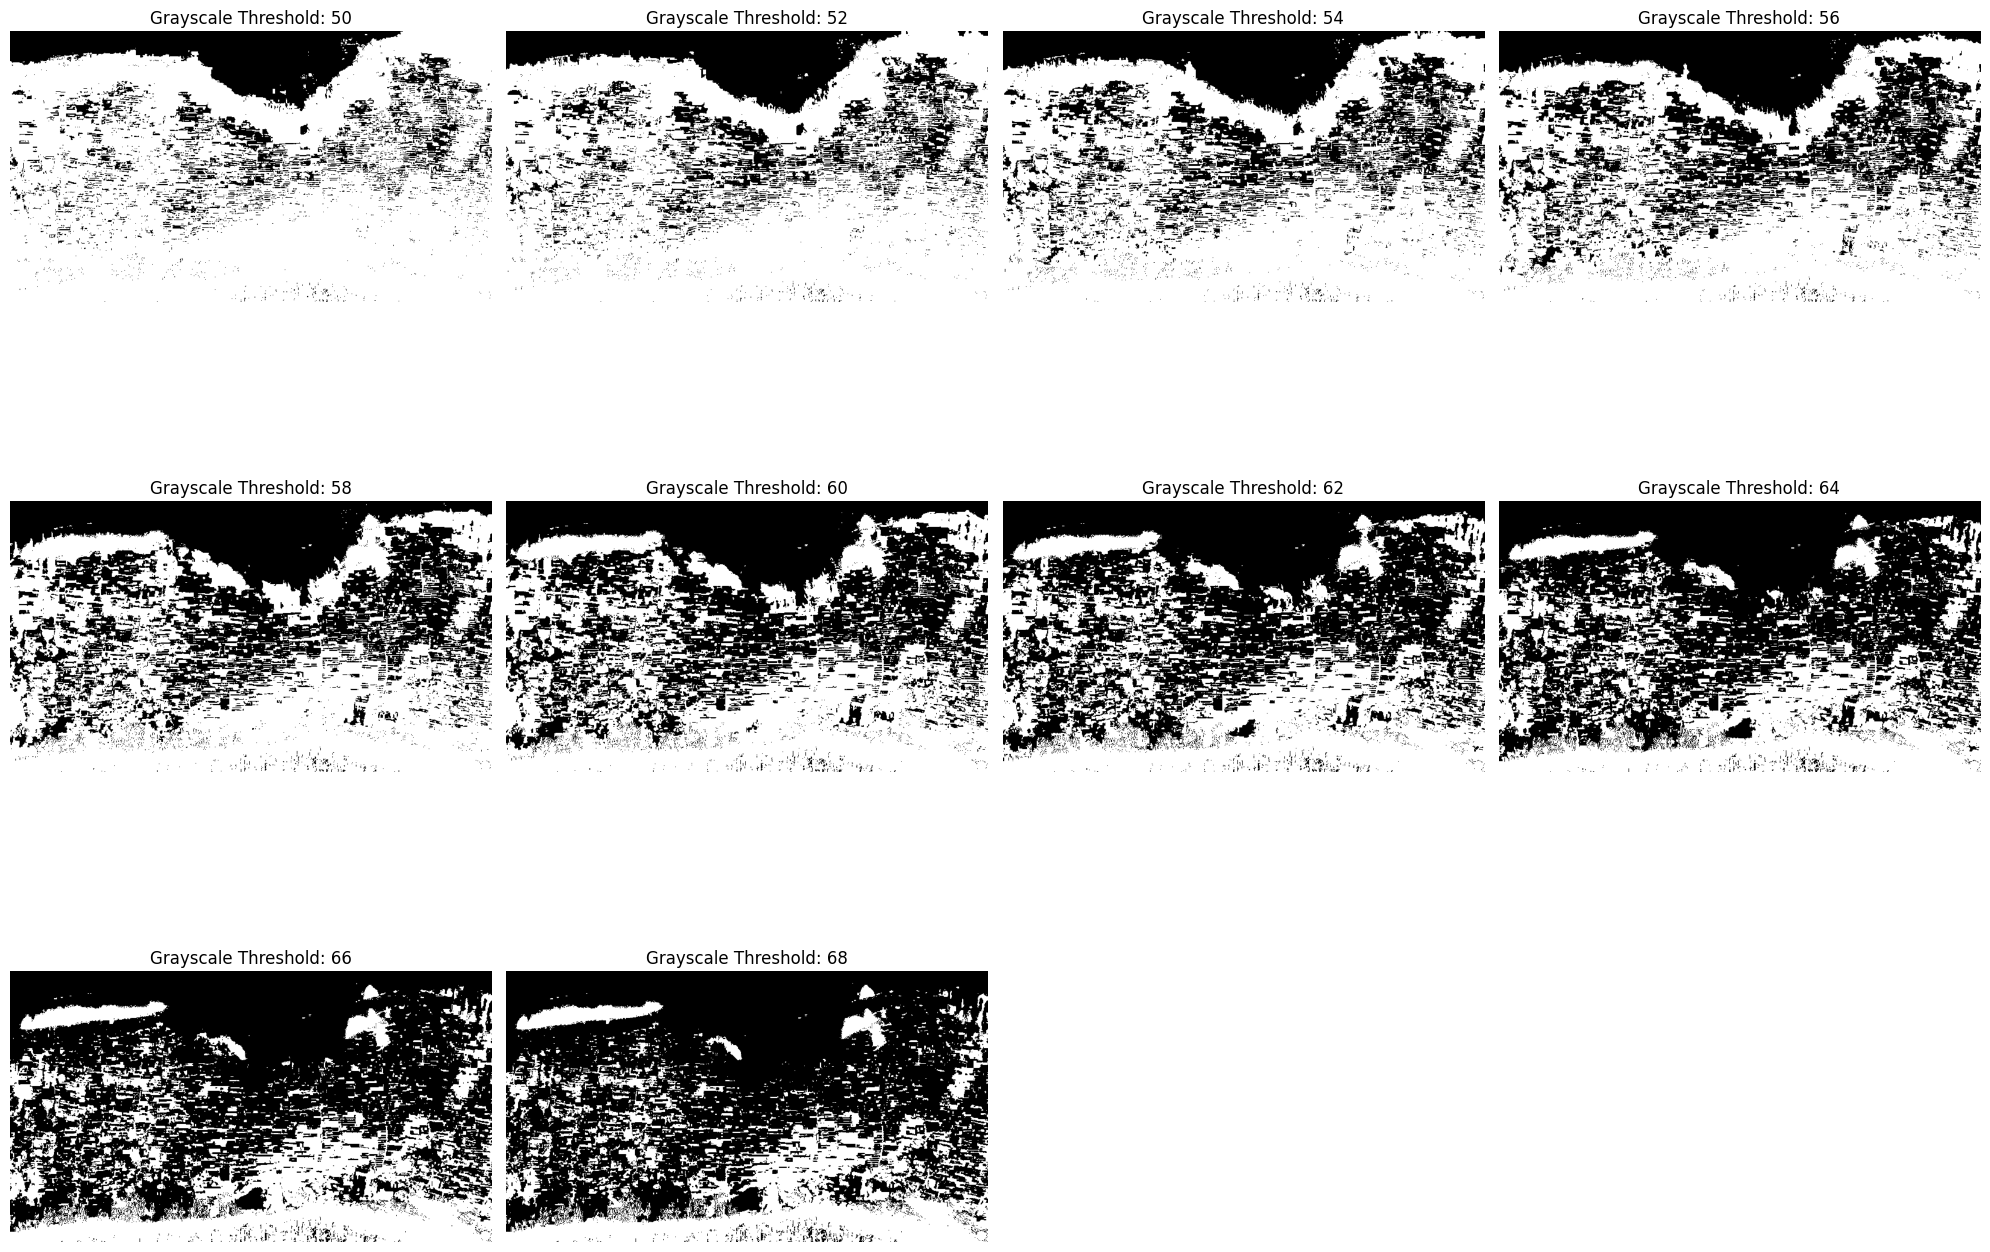

In [13]:
# Define a range of thresholds to apply to the grayscale image
# Using 25 as a step for threshold values, ranging from 0 to 225
gray_thresholds = range(50, 70, 2)

# List to store the resulting thresholded images
gray_thresholded_images = []

# Apply each threshold to the grayscale image
for thresh_value in gray_thresholds:
    _, thresholded_img = cv2.threshold(img_gray, thresh_value, 255, cv2.THRESH_BINARY)
    gray_thresholded_images.append(thresholded_img)

# Calculate the number of rows and columns required to display all images
num_images = len(gray_thresholded_images)
num_columns = 4
num_rows = num_images // num_columns + (num_images % num_columns > 0)

# Display the thresholded grayscale images
plt.figure(figsize=(20, 5 * num_rows))
for i, thresholded_img in enumerate(gray_thresholded_images):
    plt.subplot(num_rows, num_columns, i + 1)
    plt.imshow(thresholded_img, cmap='gray')
    plt.title(f'Grayscale Threshold: {gray_thresholds[i]}')
    plt.axis('off')

plt.tight_layout()
plt.show()